In [1]:
!pip install transformers
import torch
from tqdm.auto import tqdm
from transformers import AdamW
from transformers import AutoTokenizer, BertForMaskedLM

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#change sheetname
# train_df=pd.read_excel('../data/data.xlsx', sheet_name=0)
# test_df=pd.read_excel('../../data/data.xlsx', sheet_name=2)
test_df=pd.read_excel('../../data/connor.xlsx', sheet_name=0)

val_df=pd.read_excel('../../data/data.xlsx', sheet_name=1)
# noisy_train_df=pd.read_excel('../../data/noisy_train_cot_0.xlsx', sheet_name=0)

bad_chars = [';', ':', "(", ")", "-", "'", "\"", "_", ".", ",", " "]

def components(df):
    statements = list(df['statements'])
    labels = list(df['labels'])
    genes = list(df['target_genes'])
    return statements, labels, genes


In [4]:
train_df.head()

NameError: name 'train_df' is not defined

In [3]:
test_df.head()

,Unnamed: 0,target_genes,pmcid,statements,review_label,label,Remarks,labels,connor_notes
0,1436,msbA,4979069,coli conclude that the conformational transiti...,-1.0,1,ABC transporter,0,NaN
1,343,CpxR,5063474,"The results showed that, apart from the previo...",-1.0,-1,NaN,0,NaN
2,1382,mphI,5760710,MphI shares high sequence identity (94%) to ho...,1.0,1,NaN,0,Note that the actual conclusion of the linked ...
3,187,cpxA,3319533,The disruption at cpxAR operon was confirmed w...,-1.0,1,plasmid,0,NaN
4,1854,sdiA,2812512,It was recently discovered that S . Typhimuriu...,-1.0,-1,NaN,0,NaN


In [5]:
val_df.head()

,target_genes,statements,labels
0,NDM-1,5% in Indian and Pakistan hospitals . In addit...,1
1,otrC,"Additionally, the significantly enhanced vanco...",1
2,FosB,"Thus, the P1 space group appears to be the res...",1
3,CpxR,"In Klebsiella pneumoniae, CpxR is involved in ...",1
4,mfd,"3) . Thus, the reduced spontaneous mutation ra...",1


In [4]:
# train_statements, train_labels, train_genes=components(train_df)
test_statements, test_labels, test_genes=components(test_df)
val_statements, val_labels, val_genes=components(val_df)

In [74]:
noisy_train_statements, noisy_train_labels, noisy_train_genes=components(noisy_train_df)

In [5]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 4 GPU(s) available.
Device name: Quadro RTX 8000


In [6]:
torch.cuda.set_device(2)

In [7]:
import random
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
set_seed(42)    # Set seed for reproducibility

In [8]:
prompt_template_encoding_1=tokenizer.tokenize(" is ")
print(prompt_template_encoding_1)
prompt_template_encoding_2=tokenizer.tokenize(" antibiotic resistant ")
prompt_template_encoding_2

['is']


['antibiotic', 'resistant']

In [9]:
!nvidia-smi

Mon Apr  4 18:17:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:3D:00.0 Off |                  Off |
| 33%   31C    P8    34W / 260W |      3MiB / 48601MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:3F:00.0 Off |                  Off |
| 33%   

In [10]:
# !kill -9 26647

In [11]:
#prepare mask keywords

bad_chars = [';', ':', "(", ")", "-", "'", "\"", "_", ".", ",", " "]

rule1=['resistan', 'efflux']

rule2=["beta-lactamase", "beta lactamase",  "streptogramin inactivation enzyme", 
"fosfomycin inactivation enzyme",
"tetracycline inactivation enzyme ", #AMR gene
"macrolide inactivation enzyme",
"rifampin inactivation enzyme",
"aminoglycoside acetyltransferase", #"AAC",
"chloramphenicol phosphotransferase",
"aminoglycoside phosphotransferase", #"APH",
"chloramphenicol acetyltransferase", #"CAT", 
"aminoglycoside nucleotidyltransferase", #"ANT",
"lincosamide nucleotidyltransferase", #"LNU" 
"streptothricin acetyltransferase", #"SAT", 
"fusidic acid inactivation enzyme",
"Edeine acetyltransferase", 
"viomycin phosphotransferase", 
"ciprofloxacin phosphotransferase",
"Bah amidohydrolase",
"MDR",
"MRSA"]

rule3=['bla', 'mec']

rule4=['MIC', 'increase', 'fold']

antibiotics_df=pd.read_excel('../../data/antibiotics.xlsx', sheet_name=0)
temp_keywords=list(antibiotics_df['antibiotics'])
temp_keywords = [y for x in [temp_keywords, rule1] for y in x]
temp_keywords = [y for x in [temp_keywords, rule2] for y in x]
temp_keywords = [y for x in [temp_keywords, rule3] for y in x]
temp_keywords = [y for x in [temp_keywords, rule4] for y in x]
mask_keywords=[]
for i in range(len(temp_keywords)):
    keywords=temp_keywords[i].replace("-", " ").split()
#     for j in range(len(keywords)):
#         filtered_word=''.join(k for k in keywords[j] if not k in bad_chars)
    mask_keywords = [y for x in [mask_keywords, keywords] for y in x]
mask_keywords=[i for i in mask_keywords if len(i)>2]



In [12]:
mask_keywords=random.sample(mask_keywords, int(len(mask_keywords)*0.25))

In [13]:
def preprocessing_for_bert(statements, labels, genes):
    pretokenized_encodings=[]
    mask_indices=[]
    prompt_encodings=[]
    all_masks=[]
    for idx in range(len(statements)):
        sub_tokens=tokenizer.tokenize(statements[idx], add_special_tokens=True, truncation=True, max_length=512, return_tensors='pt')
        gene_encoding=tokenizer.tokenize(genes[idx])
        prompt=[]
        prompt = [y for x in [prompt, gene_encoding] for y in x]
        prompt = [y for x in [prompt, prompt_template_encoding_1] for y in x]
        if(labels[idx]==1):
            prompt.append('possibly')
        else:
            prompt.append('not')
        prompt = [y for x in [prompt, prompt_template_encoding_2] for y in x]
#         prompt.append('[SEP]')
        if(len(sub_tokens)+len(prompt)+1>512):
            sub_tokens=sub_tokens[:(512-len(prompt)-2)]
            sub_tokens.append('[SEP]')
        sub_tokens = [y for x in [sub_tokens, prompt] for y in x]
        mask_index=len(sub_tokens)-3
#         for idx in range(512-len(sub_tokens)):
#             sub_tokens.append('[PAD]')
#         pretokenized_encodings.append(sub_tokens)
        mask_indices.append(mask_index)
        prompt_encodings.append(prompt)
        
      ############################################################  
        
        #sub_tokens doesn't have [SEP] at the end
        #Exclude CLS SEP and prompt
        sub_tokens=sub_tokens[1:-(len(prompt)+1)]
        input_statement=tokenizer.convert_tokens_to_string(sub_tokens)
        tokens=input_statement.split()
        masks=[0]
        for token in tokens:
            sub_tokens=tokenizer.tokenize(token) #{'prepare_for_tokenization':True})
            word=tokenizer.convert_tokens_to_string(sub_tokens)
            #bla+target_gene
            filtered_gene=''.join(i for i in genes[idx] if not i in bad_chars)
            filtered_word=''.join(i for i in word if not i in bad_chars)
            if filtered_gene.lower() in filtered_word.lower():
                temp_list=[0]*len(sub_tokens)
            else:
                flag=0
                for keyword in mask_keywords:
                    filtered_keyword=''.join(i for i in keyword if not i in bad_chars)
                    if filtered_keyword.lower() in filtered_word.lower():
                        flag=1
                        temp_list=[1]*len(sub_tokens)
                        break
                if flag==0:
                    temp_list=[0]*len(sub_tokens)
            masks = [y for x in [masks, temp_list] for y in x]
#         if(len(masks)>512):
#             del masks[512:]
#         elif (len(masks)==512 and masks[511]==1):
#             masks[511]=0
#         else:
#             temp_list=[0]*(512-len(masks))
#             masks = [y for x in [masks, temp_list] for y in x]
        # print(masks)
        all_masks.append(masks)
        
    return prompt_encodings, mask_indices, all_masks

In [14]:
def preprocessing_for_bert_dev(statements, labels, genes):
    pretokenized_encodings=[]
    mask_indices=[]
    prompt_encodings=[]
    all_masks=[]
    for idx in range(len(statements)):
        sub_tokens=tokenizer.tokenize(statements[idx], add_special_tokens=True, truncation=True, max_length=512, return_tensors='pt')
        gene_encoding=tokenizer.tokenize(genes[idx])
        prompt=[]
        prompt = [y for x in [prompt, gene_encoding] for y in x]
        prompt = [y for x in [prompt, prompt_template_encoding_1] for y in x]
        if(labels[idx]==1):
            prompt.append('possibly')
        else:
            prompt.append('not')
        prompt = [y for x in [prompt, prompt_template_encoding_2] for y in x]
#         prompt.append('[SEP]')
        if(len(sub_tokens)+len(prompt)+1>512):
            sub_tokens=sub_tokens[:(512-len(prompt)-2)]
            sub_tokens.append('[SEP]')
        sub_tokens = [y for x in [sub_tokens, prompt] for y in x]
        mask_index=len(sub_tokens)-3
#         for idx in range(512-len(sub_tokens)):
#             sub_tokens.append('[PAD]')
#         pretokenized_encodings.append(sub_tokens)
        mask_indices.append(mask_index)
        prompt_encodings.append(prompt)
        
#       ############################################################  
        
#         #sub_tokens doesn't have [SEP] at the end
#         #Exclude CLS SEP and prompt
#         sub_tokens=sub_tokens[1:-(len(prompt)+1)]
#         input_statement=tokenizer.convert_tokens_to_string(sub_tokens)
#         tokens=input_statement.split()
#         masks=[0]
#         for token in tokens:
#             sub_tokens=tokenizer.tokenize(token) #{'prepare_for_tokenization':True})
#             word=tokenizer.convert_tokens_to_string(sub_tokens)
#             #bla+target_gene
#             filtered_gene=''.join(i for i in genes[idx] if not i in bad_chars)
#             filtered_word=''.join(i for i in word if not i in bad_chars)
#             if filtered_gene.lower() in filtered_word.lower():
#                 temp_list=[0]*len(sub_tokens)
#             else:
#                 flag=0
#                 for keyword in mask_keywords:
#                     filtered_keyword=''.join(i for i in keyword if not i in bad_chars)
#                     if filtered_keyword.lower() in filtered_word.lower():
#                         flag=1
#                         temp_list=[1]*len(sub_tokens)
#                         break
#                 if flag==0:
#                     temp_list=[0]*len(sub_tokens)
#             masks = [y for x in [masks, temp_list] for y in x]
# #         if(len(masks)>512):
# #             del masks[512:]
# #         elif (len(masks)==512 and masks[511]==1):
# #             masks[511]=0
# #         else:
# #             temp_list=[0]*(512-len(masks))
# #             masks = [y for x in [masks, temp_list] for y in x]
#         # print(masks)
#         all_masks.append(masks)
        
    return prompt_encodings, mask_indices#, all_masks

In [15]:
# # #prompt, label_mask, rule_mask
# train_pretokenized_encodings, train_mask_indices, train_rule_masks=preprocessing_for_bert(train_statements, train_labels, train_genes)
# test_pretokenized_encodings, test_mask_indices, test_rule_masks=preprocessing_for_bert(test_statements, test_labels, test_genes)

# train_pretokenized_encodings, mask_indices=preprocessing_for_bert(statements, labels, genes)
val_pretokenized_encodings, val_mask_indices=preprocessing_for_bert_dev(val_statements, val_labels, val_genes)
test_pretokenized_encodings, test_mask_indices=preprocessing_for_bert_dev(test_statements, test_labels, test_genes)

In [84]:
noisy_train_pretokenized_encodings, noisy_train_mask_indices=preprocessing_for_bert_dev(noisy_train_statements, noisy_train_labels, noisy_train_genes)

In [16]:
#prompt, label_mask, rule_mask
# train_pretokenized_strings=[]
# for idx in range(len(train_pretokenized_encodings)):
#     train_pretokenized_strings.append(tokenizer.convert_tokens_to_string(train_pretokenized_encodings[idx]))

val_pretokenized_strings=[]
for idx in range(len(val_pretokenized_encodings)):
    val_pretokenized_strings.append(tokenizer.convert_tokens_to_string(val_pretokenized_encodings[idx]))

# train_pretokenized_strings=pretokenized_strings[:int(len(pretokenized_strings) * .90)]
# val_pretokenized_strings=pretokenized_strings[int(len(pretokenized_strings) * .90):]
# train_mask_indices=mask_indices[:int(len(mask_indices) * .90)]
# val_mask_indices=mask_indices[int(len(mask_indices) * .90):]
# train_rule_masks=rule_masks[:int(len(rule_masks) * .90)]
# val_rule_masks=rule_masks[int(len(rule_masks) * .90):]

test_pretokenized_strings=[]
for idx in range(len(test_pretokenized_encodings)):
    test_pretokenized_strings.append(tokenizer.convert_tokens_to_string(test_pretokenized_encodings[idx]))

In [85]:
noisy_train_pretokenized_strings=[]
for idx in range(len(noisy_train_pretokenized_encodings)):
    noisy_train_pretokenized_strings.append(tokenizer.convert_tokens_to_string(noisy_train_pretokenized_encodings[idx]))

In [18]:
# train_statements=statements[:int(len(statements) * .90)]
# val_statements=statements[int(len(statements) * .90):]

In [17]:
def tokenize(statements, prompts, mask_ind, rule_masks):
    inputs = tokenizer(
        statements,prompts,
        max_length=512,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='pt'
    )
#     inputs['labels'] = inputs['input_ids'].clone()
    inputs['labels']=torch.ones(len(inputs['input_ids']),512, dtype=int)    
    inputs['mask_idx']=torch.zeros(len(inputs['input_ids']),1, dtype=int)
    for idx in range(len(inputs['input_ids'])):
        inputs['labels'][idx][mask_ind[idx]]=inputs['input_ids'][idx][mask_ind[idx]]
        inputs['input_ids'][idx][mask_ind[idx]]=tokenizer.mask_token_id
        #################
        ## MLM ##
        rule_mask=rule_masks[idx]
        for i in range(len(rule_mask)):
            if rule_mask[i]==1:
                inputs['labels'][idx][i]=inputs['input_ids'][idx][i]
                inputs['input_ids'][idx][i]=tokenizer.mask_token_id
        #################
        inputs['mask_idx'][idx][0]=mask_ind[idx]
#     inputs['labels'][inputs['labels'] != tokenizer.mask_token_id] = 1 # only calculate loss on masked tokens
#     inputs['labels']=[1 for i in inputs['labels'][idx] if i!=tokenizer.mask_token_id]
    return inputs

In [18]:
def tokenize_normal(statements, prompts, mask_ind):
    inputs = tokenizer(
        statements,prompts,
        max_length=512,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='pt'
    )
#     inputs['labels'] = inputs['input_ids'].clone()
    inputs['labels']=torch.ones(len(inputs['input_ids']),512, dtype=int)    
    inputs['mask_idx']=torch.zeros(len(inputs['input_ids']),1, dtype=int)
    for idx in range(len(inputs['input_ids'])):
        inputs['labels'][idx][mask_ind[idx]]=inputs['input_ids'][idx][mask_ind[idx]]
        inputs['input_ids'][idx][mask_ind[idx]]=tokenizer.mask_token_id
        #################
        ## MLM ##
#         rule_mask=rule_masks[idx]
#         for i in range(len(rule_mask)):
#             if rule_mask[i]==1:
#                 inputs['labels'][idx][i]=inputs['input_ids'][idx][i]
#                 inputs['input_ids'][idx][i]=tokenizer.mask_token_id
        #################
        inputs['mask_idx'][idx][0]=mask_ind[idx]
#     inputs['labels'][inputs['labels'] != tokenizer.mask_token_id] = 1 # only calculate loss on masked tokens
#     inputs['labels']=[1 for i in inputs['labels'][idx] if i!=tokenizer.mask_token_id]
    return inputs

In [19]:
class BookDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, index):
        input_ids = self.encodings['input_ids'][index]
        labels = self.encodings['labels'][index]
        attention_mask = self.encodings['attention_mask'][index]
        token_type_ids = self.encodings['token_type_ids'][index]
        mask_idx = self.encodings['mask_idx'][index]
        return {
            'input_ids': input_ids,
            'labels': labels,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'mask_idx': mask_idx
        }

In [20]:
class Seq_BookDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, index):
        input_ids = self.encodings['input_ids'][index]
        labels = self.encodings['labels'][index]
        attention_mask = self.encodings['attention_mask'][index]
        token_type_ids = self.encodings['token_type_ids'][index]
        mask_idx = self.encodings['mask_idx'][index]
        seq_labels = self.encodings['seq_labels'][index]
        return {
            'input_ids': input_ids,
            'labels': labels,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'mask_idx': mask_idx,
            'seq_labels': seq_labels 
        }

In [21]:
# train_inputs_MLM=tokenize(train_statements, train_pretokenized_strings, train_mask_indices, train_rule_masks)
# val_inputs=tokenize(val_statements, val_pretokenized_strings, val_mask_indices, val_rule_masks)
# test_inputs=tokenize(test_statements, test_pretokenized_strings, test_mask_indices, test_rule_masks)

In [22]:
# train_inputs_normal=tokenize_normal(train_statements, train_pretokenized_strings, train_mask_indices)
val_inputs_normal=tokenize_normal(val_statements, val_pretokenized_strings, val_mask_indices)
test_inputs_normal=tokenize_normal(test_statements, test_pretokenized_strings, test_mask_indices)

In [90]:
noisy_train_inputs_normal=tokenize_normal(noisy_train_statements, noisy_train_pretokenized_strings, noisy_train_mask_indices)

In [25]:
# import pickle
# ftr = open('final_train_inputs_new_prompt2_MLM_50.txt', 'wb')
# pickle.dump(train_inputs, ftr)
# ftr.close()
# # fv = open('val_inputs_prompt1_MLM.txt', 'wb')
# # pickle.dump(val_inputs, fv)
# # fv.close()
# # ft = open('test_inputs_prompt1_MLM.txt', 'wb')
# # pickle.dump(test_inputs, ft)
# # ft.close()

In [26]:
# import pickle
# with open('final_train_inputs_new_prompt2_MLM_50.txt', 'rb') as handle:
#     data = handle.read()
# train_inputs_MLM = pickle.loads(data)

# # with open('val_inputs_prompt1_MLM.txt', 'rb') as handle:
# #     data = handle.read()
# # val_inputs_MLM = pickle.loads(data)

# # with open('test_inputs_prompt1_MLM.txt', 'rb') as handle:
# #     data = handle.read()
# # test_inputs_MLM = pickle.loads(data)

In [27]:
# ###################
# train_dataset=BookDataset(train_inputs)
# ####################

In [28]:
# ## create labels for sequential optimization
# train_inputs_MLM['seq_labels']=train_inputs_MLM['labels']
# for i in range(len(train_inputs_MLM['seq_labels'])):
#     train_inputs_MLM['seq_labels'][i][train_inputs_MLM['mask_idx'][i][0]]=tokenizer.mask_token_id

In [23]:
# train_dataset_normal=BookDataset(train_inputs_normal)
val_dataset=BookDataset(val_inputs_normal)
test_dataset=BookDataset(test_inputs_normal)
# train_dataset=BookDataset(train_inputs_MLM)

In [91]:
noisy_train_dataset=BookDataset(noisy_train_inputs_normal)

In [30]:
# train_dataset=Seq_BookDataset(train_inputs_MLM)

In [24]:
print(tokenizer.convert_tokens_to_ids("not"))
print(tokenizer.convert_tokens_to_ids("possibly"))

2084
6553


In [25]:
import torch.nn.functional as F

In [26]:
# def train(model, train_dataloader):

#     set_seed(42)
#     optimizer = AdamW(model.parameters(), lr=2e-05)
#     model.train()

#     # Tracking variables
#     train_loss = []
#     tp=0
#     tn=0
#     fp=0
#     fn=0
#     unk_pos=0
#     unk_neg=0
#     # for epoch in range(epochs):
#     #     loop = tqdm(train_dataloader)
#     for batch in train_dataloader:
#         optimizer.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         labels = batch['labels'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss   
#         train_loss.append(loss.item())
#         b_probabilities = F.softmax(outputs.logits, dim=-1)
#         # Get the predictions
#         preds = torch.argmax(b_probabilities, dim=2)
#     #     print("preds: ", preds[0])
#     #     print("labels: ", labels[0])
#         # Calculate the accuracy rate
#         for i in range(len(batch['input_ids'])):
#             pred=preds[i][batch['mask_idx'][i][0]]
#             label=labels[i][batch['mask_idx'][i][0]]
# #             print("pred: ", tokenizer.convert_ids_to_tokens(pred.item()))
# #             print("label: ", tokenizer.convert_ids_to_tokens(label.item()))
#             if pred == 6553 and label == 6553: 
#                 tp+=1
#             elif pred == 6553 and label == 2084:
#                 fp+=1
#             elif pred == 2084 and label == 2084:
#                 tn+=1
#             elif pred == 2084 and label == 6553:
#                 fn+=1
#             elif label == 6553:
#                 unk_pos+=1
#             else:
#                 unk_neg+=1

#         loss.backward()
#         optimizer.step()


# #     train_loss = np.mean(train_loss)
# #     #balanced accuracy = (tpr+tnr)/2
# #     train_precision=tp/(tp+fp)
# #     train_recall=tp/(tp+fn+unk_pos)
# #     train_f1=2*train_precision*train_recall/(train_precision+train_recall)
# #     train_balanced_accuracy = (train_recall+(tn/(tn+fp+unk_neg)))/2
# #     train_accuracy = (tp+tn)/(tp+tn+fp+fn+unk_pos+unk_neg)
#     train_total_not_predicted = unk_pos+unk_neg
    
    
#     train_loss = np.mean(train_loss)
# #     train_accuracy = np.mean(train_accuracy)
    
#     beta=0.5
#     train_precision_pos=tp/(tp+fp)
#     train_recall_pos=tp/(tp+fn+unk_pos)
#     train_f1_pos=2*train_precision_pos*train_recall_pos/(train_precision_pos+train_recall_pos)
# #     train_balanced_accuracy = (train_recall+(tn/(tn+fp)))/2
#     train_precision_neg=tn/(tn+fn)
#     train_recall_neg=tn/(tn+fp+unk_neg)
#     train_f1_neg=2*train_precision_neg*train_recall_neg/(train_precision_neg+train_recall_neg)
#     train_f1_beta_pos=((1+beta*beta)*train_precision_pos*train_recall_pos)/((1+beta*beta)*train_precision_pos*train_recall_pos+beta*beta*train_precision_pos+train_recall_pos)
    
#     train_accuracy = (tp+tn)/(tp+tn+fp+fn+unk_pos+unk_neg)
# #     train_precision_neg=tn/(tn+fn)
# #     train_recall_neg=tn/(tn+fp)
# #     train_f1_neg=2*train_precision_pos*train_recall_pos/(train_precision_pos+train_recall_pos)
#     train_f1_beta_neg=((1+beta*beta)*train_precision_neg*train_recall_neg)/((1+beta*beta)*train_precision_neg*train_recall_neg+beta*beta*train_precision_neg+train_recall_neg)
    
#     train_f1_beta=(train_f1_beta_pos+train_f1_beta_neg)/2
#     print(f" check_train_accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

#     return [train_loss, train_accuracy, train_precision_pos, train_recall_pos, train_f1_pos, train_f1_beta_pos,train_precision_neg, train_recall_neg, train_f1_neg, train_f1_beta_neg, train_f1_beta, train_total_not_predicted]

# #     return [train_loss, train_precision, train_recall, train_f1, train_balanced_accuracy, train_accuracy, train_total_not_predicted] 

#     #note total=11264


In [27]:
# def train_2(model, train_dataloader):

#     set_seed(42)
#     optimizer = AdamW(model.parameters(), lr=2e-05)
#     model.train()

# #     # Tracking variables
#     train_loss = []
# #     tp=0
# #     tn=0
# #     fp=0
# #     fn=0
# #     unk_pos=0
# #     unk_neg=0
#     # for epoch in range(epochs):
#     #     loop = tqdm(train_dataloader)
#     for batch in train_dataloader:
#         optimizer.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         labels = batch['seq_labels'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss   
#         train_loss.append(loss.item())

# #         # Get the predictions
# #         preds = torch.argmax(outputs.logits, dim=2)
# #     #     print("preds: ", preds[0])
# #     #     print("labels: ", labels[0])
# #         # Calculate the accuracy rate
# #         for i in range(len(batch['input_ids'])):
# #             pred=preds[i][batch['mask_idx'][i][0]]
# #             label=labels[i][batch['mask_idx'][i][0]]
# # #             print("pred: ", tokenizer.convert_ids_to_tokens(pred.item()))
# # #             print("label: ", tokenizer.convert_ids_to_tokens(label.item()))
# #             if pred == 6228 and label == 6228: 
# #                 tp+=1
# #             elif pred == 6228 and label == 7198:
# #                 fp+=1
# #             elif pred == 7198 and label == 7198:
# #                 tn+=1
# #             elif pred == 7198 and label == 6228:
# #                 fn+=1
# #             elif label == 6228:
# #                 unk_pos+=1
# #             else:
# #                 unk_neg+=1

#         loss.backward()
#         optimizer.step()
#     train_loss = np.mean(train_loss)
#     return train_loss
# #     train_loss = np.mean(train_loss)
# #     #balanced accuracy = (tpr+tnr)/2
# #     train_precision=tp/(tp+fp)
# #     train_recall=tp/(tp+fn+unk_pos)
# #     train_f1=2*train_precision*train_recall/(train_precision+train_recall)
# #     train_balanced_accuracy = (train_recall+(tn/(tn+fp+unk_neg)))/2
# #     train_accuracy = (tp+tn)/(tp+tn+fp+fn+unk_pos+unk_neg)
# #     train_total_not_predicted = unk_pos+unk_neg

# #     return [train_loss, train_precision, train_recall, train_f1, train_balanced_accuracy, train_accuracy, train_total_not_predicted] 

#     #note total=11264


In [26]:
# Specify loss function
# loss_fn = torch.nn.CrossEntropyLoss()
# model.to(device)
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
#     val_accuracy = []
    val_loss = []
    pred_label=[]
    tp=0
    tn=0
    fp=0
    fn=0
    unk_pos=0
    unk_neg=0
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids = batch['input_ids'].to(device)
        b_labels = batch['labels'].to(device)
        b_attn_mask = batch['attention_mask'].to(device)
        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attn_mask, labels=b_labels)

        # Compute loss
#         loss=torch.nn.functional.cross_entropy(outputs.logits.view(-1, tokenizer.vocab_size), b_labels.view(-1))
        loss=outputs.loss
#         loss = loss_fn(outputs.logits, b_labels)
        val_loss.append(loss.item())
        b_probabilities = F.softmax(outputs.logits, dim=-1)
        
#         pred = torch.argmax( scores[0][7]).item()
#         print("predicted token:", pred, tokenizer.convert_ids_to_tokens([pred])  )
#         print(NLLLos( logSoftmax(torch.unsqueeze(scores[0][7], 0)), torch.tensor([pred]))) #the same as F.cross_entropy(scores.view(-1, tokenizer.vocab_size), labels.view(-1))
        
        # Get the predictions
        preds = torch.argmax(outputs.logits, dim=2)
        
#         print("preds: ", preds[0])
#         print("labels: ", b_labels[0])
        # Calculate the accuracy rate
#         for i in batch:
#         print(b_probabilities.shape)
#         print(preds.shape)
        for i in range(len(batch['input_ids'])):
            
            pred=preds[i][batch['mask_idx'][i][0]]
            label=b_labels[i][batch['mask_idx'][i][0]]
#             print("pred: ", preds[i])
#             print("label: ", labels[i])
            prob.append(b_probabilities[i][batch['mask_idx'][i][0]][6553].item())
            if pred == 6553 and label == 6553: 
                tp+=1
                pred_label.append(1)
#                 prob_tp.append(b_probabilities[i][batch['mask_idx'][i][0]][6553].item())
            elif pred == 6553 and label == 2084:
                fp+=1
                pred_label.append(1)
#                 prob_fp.append(b_probabilities[i][batch['mask_idx'][i][0]][6553].item())
            elif pred == 2084 and label == 2084:
                tn+=1
                pred_label.append(0)
            elif pred == 2084 and label == 6553:
                fn+=1    
                pred_label.append(0)
            elif label == 6553:
                unk_pos+=1
                pred_label.append(1)
            else:
                unk_neg+=1
                pred_label.append(0)
#         accuracy = (preds == b_labels).cpu().numpy().mean() * 100
#         val_accuracy.append(accuracy)
    val_total_not_predicted = unk_pos+unk_neg
    # Compute the average accuracy and loss over the validation set.
    beta=0.5
    val_loss = np.mean(val_loss)
#     val_accuracy = np.mean(val_accuracy)
    try:
        val_precision_pos=tp/(tp+fp)
    except ZeroDivisionError:
        val_precision_pos=0
    try:
        val_recall_pos=tp/(tp+fn)
    except ZeroDivisionError:
        val_recall_pos=0
    try:
        val_f1_pos=2*val_precision_pos*val_recall_pos/(val_precision_pos+val_recall_pos)
    except ZeroDivisionError:
        val_f1_pos=0
    try:
        val_f1_beta_pos=((1+beta*beta)*val_precision_pos*val_recall_pos)/((1+beta*beta)*val_precision_pos*val_recall_pos+beta*beta*val_precision_pos+val_recall_pos)
    except ZeroDivisionError:
        val_f1_beta_pos=0
#     try:
#         val_balanced_accuracy = (val_recall+(tn/(tn+fp)))/2
#     except ZeroDivisionError:
#         val_balanced_accuracy =0
    try:
        val_precision_neg=tn/(tn+fn)
    except ZeroDivisionError:
        val_precision_neg=0
    try:
        val_recall_neg=tn/(tn+fp)
    except ZeroDivisionError:
        val_recall_neg=0
    try:
        val_f1_neg=2*val_precision_neg*val_recall_neg/(val_precision_neg+val_recall_neg)
    except ZeroDivisionError:
        val_f1_neg=0
    try:
        val_f1_beta_neg=((1+beta*beta)*val_precision_neg*val_recall_neg)/((1+beta*beta)*val_precision_neg*val_recall_neg+beta*beta*val_precision_neg+val_recall_neg)
    except ZeroDivisionError:
        val_f1_beta_neg=0
    try:
        val_f1_beta=(val_f1_beta_pos+val_f1_beta_neg)/2
    except ZeroDivisionError:
        val_f1_beta=0
        
    try:
        val_accuracy=(tp+tn)/(tp+tn+fp+fn)
    except ZeroDivisionError:
        val_accuracy=0
        print("ZeroDivisionError")

    return [val_loss, val_accuracy, val_precision_pos, val_recall_pos, val_f1_pos, val_f1_beta_pos,val_precision_neg, val_recall_neg, val_f1_neg, val_f1_beta_neg, val_f1_beta, val_total_not_predicted, pred_label] 
        
    
#     val_accuracy = np.mean(val_accuracy)



In [28]:
batch_size=[8, 12]
# learning_rate=[2e-5, 3e-5, 5e-5]
epochs=[1,2,3,4,5,6,7,8,9,10]
result_train=[[[] for bs in batch_size] for e in epochs]
result_val=[[[] for bs in batch_size] for e in epochs]
#result_val[e][lr][bs]=[metrics]

# Rule_mask_25

In [ ]:
# import pickle
# print("val_loss, val_accuracy, val_precision_pos, val_recall_pos, val_f1_pos, val_f1_beta_pos, ...negs, f1_beta")
# best_model_val_acc=-1
# best_model_val_f1=-1
# best_model_val_f1_beta=-1
# for bs in range(len(batch_size)):
#     train_dataloader = torch.utils.data.DataLoader(
#         train_dataset_normal,
#         batch_size=batch_size[bs],
#         #shuffle=True
#     )
#     val_dataloader = torch.utils.data.DataLoader(
#         val_dataset,
#         batch_size=batch_size[bs],
#     )
#     train_dataloader_MLM = torch.utils.data.DataLoader(
#                     train_dataset,
#                     batch_size=batch_size[bs],
#                     #shuffle=True
#     )
#     torch.cuda.empty_cache() 
#     model = BertForMaskedLM.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
#     model.to(device)
#     for e in range(len(epochs)): 
#         if e==0 or e==1:
#             with open("prompt2_25_result_train.txt", "wb") as ft:   #Pickling
#                 result_train[e][bs]=train(model, train_dataloader)
#                 pickle.dump(result_train, ft)
#             ft.close()
#             with open("prompt2_25_result_val.txt", "wb") as fv:   #Pickling
#                 result_val[e][bs]=evaluate(model, val_dataloader)
#                 pickle.dump(result_val, fv)
#             fv.close()
#         else:
#             with open("prompt2_25_result_train.txt", "wb") as ft:   #Pickling
#                 train_mlm_loss=train_2(model, train_dataloader_MLM)
#                 result_train[e][bs]=train(model, train_dataloader)
#                 result_train[e][bs][0]=(result_train[e][bs][0]+train_mlm_loss)/2
#                 pickle.dump(result_train, ft)
#             ft.close()
#             with open("prompt2_25_result_val.txt", "wb") as fv:   #Pickling
#                 result_val[e][bs]=evaluate(model, val_dataloader)
#                 pickle.dump(result_val, fv)
#             fv.close()
#         print(f"batch_size: {batch_size[bs]} epoch: {epochs[e]} result_train: {result_train[e][bs]} result_val: {result_val[e][bs]}")
# #             if(e>1 and result_val[e][lr][bs][5]<result_val[e-1][lr][bs][5]):
# #                 print("Early stopping")
# #                 break
#         if result_val[e][bs][1] > best_model_val_acc:
#             best_model_val_acc=result_val[e][bs][1]
# #                 !rmdir model_prompt1_MLM
#             print(best_model_val_acc)
#             model.save_pretrained(save_directory='./prompt2/model/microf1/prompt2_25/saved_model')
        
#         if result_val[e][bs][4] > best_model_val_f1:
#             best_model_val_f1=result_val[e][bs][4]
# #                 !rmdir model_prompt1_MLM
#             print(best_model_val_acc)
#             model.save_pretrained(save_directory='./prompt2/model/f1/prompt2_25/saved_model')
#         if result_val[e][bs][10] > best_model_val_f1_beta:
#             best_model_val_f1_beta=result_val[e][bs][10]
# #                 !rmdir model_prompt1_MLM
#             print(best_model_val_acc)
#             model.save_pretrained(save_directory='./prompt2/model/f1beta/prompt2_25/saved_model')

val_loss, val_accuracy, val_precision_pos, val_recall_pos, val_f1_pos, val_f1_beta_pos, ...negs, f1_beta


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


 check_train_accuracy: 0.9569377990430622
batch_size: 8 epoch: 1 result_train: [0.03560936488967764, 0.7031000319590923, 0.9610758801661928, 0.7023010546500479, 0.8115594127966023, 0.47232670607200433, 0.9528444732857452, 0.7038990092681368, 0.8096682290230678, 0.4708711918760021, 0.47159894897400323, 3320] result_val: [0.0038269285450572474, 0.5174825174825175, 0.5091575091575091, 0.972027972027972, 0.6682692307692307, 0.3601036269430052, 0.6923076923076923, 0.06293706293706294, 0.1153846153846154, 0.1875, 0.27380181347150256, 0]
0.5174825174825175
0.5174825174825175
0.5174825174825175
 check_train_accuracy: 0.9865653738504598
batch_size: 8 epoch: 2 result_train: [0.00010844600677617741, 0.9856983061681048, 0.9845442957297642, 0.9873761585170981, 0.9859581937131005, 0.49624941773615827, 0.9886017017177717, 0.9840204538191115, 0.9863057579883079, 0.49690142663482023, 0.4965754221854892, 11] result_val: [0.011628056483437947, 0.4965034965034965, 0.4982456140350877, 0.993006993006993, 0.

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#######################################################

In [37]:
# import pickle
# print("val_loss, val_accuracy, val_precision_pos, val_recall_pos, val_f1_pos, val_f1_beta_pos, ...negs, f1_beta")
# best_model_val_acc=0.5454545454545454
# best_model_val_f1=0.6798029556650246
# best_model_val_f1_beta=0.3214854111405836
# for bs in range(len(batch_size)):
#     train_dataloader = torch.utils.data.DataLoader(
#         train_dataset_normal,
#         batch_size=batch_size[bs],
#         #shuffle=True
#     )
#     val_dataloader = torch.utils.data.DataLoader(
#         val_dataset,
#         batch_size=batch_size[bs],
#     )
#     train_dataloader_MLM = torch.utils.data.DataLoader(
#                     train_dataset,
#                     batch_size=batch_size[bs],
#                     #shuffle=True
#     )
#     torch.cuda.empty_cache() 
#     model = BertForMaskedLM.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
#     model.to(device)
#     for e in range(len(epochs)): 
#         if bs==0:
#             continue
#         if e==0 or e==1:
#             with open("prompt2_25_result_train.txt", "wb") as ft:   #Pickling
#                 result_train[e][bs]=train(model, train_dataloader)
#                 pickle.dump(result_train, ft)
#             ft.close()
#             with open("prompt2_25_result_val.txt", "wb") as fv:   #Pickling
#                 result_val[e][bs]=evaluate(model, val_dataloader)
#                 pickle.dump(result_val, fv)
#             fv.close()
#         else:
#             with open("prompt2_25_result_train.txt", "wb") as ft:   #Pickling
#                 train_mlm_loss=train_2(model, train_dataloader_MLM)
#                 result_train[e][bs]=train(model, train_dataloader)
#                 result_train[e][bs][0]=(result_train[e][bs][0]+train_mlm_loss)/2
#                 pickle.dump(result_train, ft)
#             ft.close()
#             with open("prompt2_25_result_val.txt", "wb") as fv:   #Pickling
#                 result_val[e][bs]=evaluate(model, val_dataloader)
#                 pickle.dump(result_val, fv)
#             fv.close()
#         print(f"batch_size: {batch_size[bs]} epoch: {epochs[e]} result_train: {result_train[e][bs]} result_val: {result_val[e][bs]}")
# #             if(e>1 and result_val[e][lr][bs][5]<result_val[e-1][lr][bs][5]):
# #                 print("Early stopping")
# #                 break
#         if result_val[e][bs][1] > best_model_val_acc:
#             best_model_val_acc=result_val[e][bs][1]
# #                 !rmdir model_prompt1_MLM
#             print(best_model_val_acc)
#             model.save_pretrained(save_directory='./prompt2/model/microf1/prompt2_25/saved_model')
        
#         if result_val[e][bs][4] > best_model_val_f1:
#             best_model_val_f1=result_val[e][bs][4]
# #                 !rmdir model_prompt1_MLM
#             print(best_model_val_acc)
#             model.save_pretrained(save_directory='./prompt2/model/f1/prompt2_25/saved_model')
#         if result_val[e][bs][10] > best_model_val_f1_beta:
#             best_model_val_f1_beta=result_val[e][bs][10]
# #                 !rmdir model_prompt1_MLM
#             print(best_model_val_acc)
#             model.save_pretrained(save_directory='./prompt2/model/f1beta/prompt2_25/saved_model')

val_loss, val_accuracy, val_precision_pos, val_recall_pos, val_f1_pos, val_f1_beta_pos, ...negs, f1_beta


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another ta

 check_train_accuracy: 0.9774143302180686
batch_size: 12 epoch: 1 result_train: [0.05835484872072755, 0.2005433045701502, 0.9821810406272273, 0.220198146372643, 0.35974415872601484, 0.36727078891257997, 0.9716738197424892, 0.1808884627676574, 0.304997979253671, 0.34141633490167694, 0.35434356190712846, 9948] result_val: [0.0033711466130625922, 0.5300353356890459, 0.518796992481203, 0.965034965034965, 0.6748166259168704, 0.3637322087506589, 0.7058823529411765, 0.08571428571428572, 0.15286624203821655, 0.22388059701492538, 0.29380640288279214, 3]
 check_train_accuracy: 0.9867448586118251
batch_size: 12 epoch: 2 result_train: [0.00014697527657251026, 0.981383828699265, 0.9852682145716574, 0.9832214765100671, 0.9842437814924418, 0.49618566843539835, 0.9882315008866678, 0.9795461808884628, 0.9838696733809487, 0.496597537265068, 0.4963916028502332, 68] result_val: [0.005413507924548829, 0.5209790209790209, 0.5109489051094891, 0.9790209790209791, 0.6714628297362111, 0.36101083032490977, 0.75,

adjustment for the runtime error

In [38]:
#pick the best model
max_result=-1
for e in range(len(epochs)):
    for bs in range(len(batch_size)):
        if(len(result_val[e][bs])!=0):
            if(result_val[e][bs][1]>max_result):
                max_result=result_val[e][bs][1]
                max_e=epochs[e]
                max_bs=batch_size[bs]
                    
max_result,max_e,max_bs

(0.5699300699300699, 6, 12)

In [27]:
test_dataloader = torch.utils.data.DataLoader(
                test_dataset,
                batch_size=12,
                )

In [27]:
val_dataloader = torch.utils.data.DataLoader(
                val_dataset,
                batch_size=12,
                )

In [95]:
noisy_train_dataloader = torch.utils.data.DataLoader(
                noisy_train_dataset,
                batch_size=12,
                )

In [41]:
torch.cuda.empty_cache() 
model = BertForMaskedLM.from_pretrained("./prompt2/model/microf1/prompt2_25/saved_model")
model.to(device)
max_result_test=evaluate(model, test_dataloader)
print(f"batch_size: {max_bs} epoch: {max_e} result_test: {max_result_test}")

batch_size: 12 epoch: 6 result_test: [0.006218405920567682, 0.6299212598425197, 0.601063829787234, 0.9216965742251223, 0.7276239536381197, 0.39247013059183106, 0.7635467980295566, 0.29245283018867924, 0.4229195088676671, 0.3660840812470477, 0.3792771059194394, 0]


In [29]:
torch.cuda.empty_cache() 
model = BertForMaskedLM.from_pretrained("../../prompt2/prompt2/model/microf1/prompt2_25/saved_model")
model.to(device)
prob=[]
prob_tp=[]
prob_fp=[]
max_result_test=evaluate(model, val_dataloader)
print(f"batch_size: {1200} epoch: {600} result_test: {max_result_test}")

batch_size: 1200 epoch: 600 result_test: [0.0073179388421650655, 0.5699300699300699, 0.5423728813559322, 0.8951048951048951, 0.6754617414248021, 0.37058482918355534, 0.7, 0.24475524475524477, 0.3626943005181347, 0.3378378378378379, 0.3542113335106966, 0, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 

-------------------------------------------------

/home/sidhant/anaconda3/envs/sid/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.9999, 1.0)

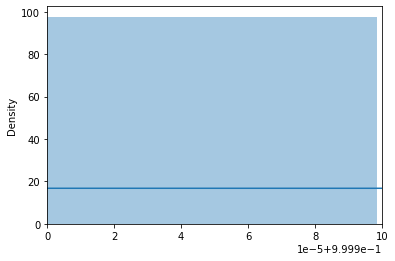

In [49]:
# prob_tp.to_list()
# prob_tp=torch.stack(prob_tp)
# prob_tp

import seaborn as sns

# # Encode our concatenated data
# encoded_seq = [tokenizer.encode(seq, add_special_tokens=True) for seq in statements]

# token_len=[]
# # Find the maximum length
# token_len=[len(sent) for sent in encoded_seq]
# # print('Max length: ', max_len)
sns.distplot(prob_tp)
plt.xlim([0.9999, 1.0])
# plt.xlabel('Token count')

In [44]:
prob_tp

[0.9999939203262329,
 0.999997615814209,
 0.9999942779541016,
 0.9999498128890991,
 0.9999966621398926,
 0.9999855756759644,
 0.9999344348907471,
 0.9999971389770508,
 0.9999963045120239,
 0.9999983310699463,
 0.9999674558639526,
 0.9999850988388062,
 0.9999829530715942,
 0.9951539039611816,
 0.999982476234436,
 0.9999830722808838,
 0.9993053674697876,
 0.9999779462814331,
 0.9999849796295166,
 0.9999912977218628,
 0.9999014139175415,
 0.9999407529830933,
 0.9999902248382568,
 0.9999574422836304,
 0.9832913279533386,
 0.9999929666519165,
 0.999901533126831,
 0.9999624490737915,
 0.9978386759757996,
 0.9999943971633911,
 0.9999805688858032,
 0.9999653100967407,
 0.9999860525131226,
 0.999970555305481,
 0.9999969005584717,
 0.9999861717224121,
 0.999893069267273,
 0.9996309280395508,
 0.9999687671661377,
 0.999967098236084,
 0.9999850988388062,
 0.9999901056289673,
 0.991899847984314,
 0.9999700784683228,
 0.9999955892562866,
 0.9975456595420837,
 0.9993865489959717,
 0.9999959468841553,

/home/sidhant/anaconda3/envs/sid/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.9999, 1.0)

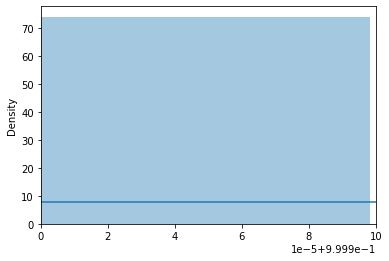

In [48]:
# prob_tp.to_list()
# prob_tp=torch.stack(prob_tp)
# prob_tp

import seaborn as sns

# # Encode our concatenated data
# encoded_seq = [tokenizer.encode(seq, add_special_tokens=True) for seq in statements]

# token_len=[]
# # Find the maximum length
# token_len=[len(sent) for sent in encoded_seq]
# # print('Max length: ', max_len)
sns.distplot(prob_fp)
plt.xlim([0.9999, 1.0])
# plt.xlabel('Token count')

In [45]:
prob_fp

[0.9999582767486572,
 0.9980798959732056,
 0.9999982118606567,
 0.9999947547912598,
 0.9997144341468811,
 0.9999115467071533,
 0.9998557567596436,
 0.9999873638153076,
 0.9999463558197021,
 0.9999681711196899,
 0.9996938705444336,
 0.9999878406524658,
 0.9999911785125732,
 0.9515300393104553,
 0.9999872446060181,
 0.969340980052948,
 0.9999759197235107,
 0.9999780654907227,
 0.9999898672103882,
 0.9999955892562866,
 0.9944759011268616,
 0.999980092048645,
 0.9927709698677063,
 0.999992847442627,
 0.9999563694000244,
 0.9999850988388062,
 0.9999866485595703,
 0.9999591112136841,
 0.9999693632125854,
 0.9999645948410034,
 0.999639630317688,
 0.9981623291969299,
 0.9999853372573853,
 0.9342369437217712,
 0.999972939491272,
 0.9995290040969849,
 0.9617842435836792,
 0.9231759309768677,
 0.9999661445617676,
 0.9999712705612183,
 0.9880405068397522,
 0.999129593372345,
 0.9996750354766846,
 0.9747108221054077,
 0.9987762570381165,
 0.8452403545379639,
 0.872645914554596,
 0.9999843835830688,

In [42]:
print(len(prob_tp))
print(len(prob_fp))
tp=len(prob_tp)
fp=len(prob_fp)
precision=tp/(tp+fp)
recall=tp/143
f1=2*precision*recall/(precision+recall)
print(precision)
print(recall)
print(f1)

128
108
0.5423728813559322
0.8951048951048951
0.6754617414248021


In [36]:
tp=0
fp=0
for i in range(len(prob_tp)):
    if prob_tp[i]>0.99999:
        tp+=1
for i in range(len(prob_fp)):
    if prob_fp[i]>0.99999:
        fp+=1
print(tp)
print(fp)
precision=tp/(tp+fp)
recall=tp/143
f1=2*precision*recall/(precision+recall)
print(precision)
print(recall)
print(f1)

20
6
0.7692307692307693
0.13986013986013987
0.2366863905325444


In [ ]:
torch.cuda.empty_cache() 
model = BertForMaskedLM.from_pretrained("../../prompt2/prompt2/model/microf1/prompt2_25/saved_model")
model.to(device)
prob=[]
prob_tp=[]
prob_fp=[]
max_result_noisy_train=evaluate(model, noisy_train_dataloader)
print(f"batch_size: {12} epoch: {3} result_test: {max_result_noisy_train[:-1]}")

In [97]:
len(max_result_noisy_train[-1])

18475

In [28]:
import pickle
with open("test_labels/prompt2_25_cot1.txt", "wb") as f:   #Pickling
    prompt2_labels=max_result_noisy_train[-1]
    pickle.dump(prompt2_labels, f)
f.close()

In [30]:
len(max_result_test[-1])

286

In [34]:
len(prob)

2000

In [31]:
import pickle
with open("val_labels/prompt2_25_labels.txt", "wb") as f:   #Pickling
    prompt2_labels=max_result_test[-1]
    pickle.dump(prompt2_labels, f)
f.close()

# 2000eval

In [32]:
torch.cuda.empty_cache() 
model = BertForMaskedLM.from_pretrained("../../prompt2/prompt2/model/microf1/prompt2_25/saved_model")
model.to(device)
prob=[]
# prob_tp=[]
# prob_fp=[]
max_result_test=evaluate(model, test_dataloader)
print(f"batch_size: {12} epoch: {3} result_test: {max_result_test}")

batch_size: 12 epoch: 3 result_test: [0.0060774787033181215, 0.638, 0.6091185410334347, 0.925207756232687, 0.7346041055718476, 0.3953286514637418, 0.7718309859154929, 0.29880043620501634, 0.43081761006289304, 0.3695710817372538, 0.3824498666004978, 0, [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [28]:
import pickle
with open("2000/test_labels/prompt2_25_labels.txt", "wb") as f:   #Pickling
    prompt2_labels=max_result_test[-1]
    pickle.dump(prompt2_labels, f)
f.close()

In [33]:
import pickle
with open("2000/test_labels/prompt2_25_prob.txt", "wb") as f:   #Pickling
    pickle.dump(prob, f)
f.close()

In [45]:
torch.cuda.empty_cache() 
model = BertForMaskedLM.from_pretrained("../../prompt2/prompt2/model/f1/prompt2_50/saved_model")
model.to(device)
prob=[]
# prob_tp=[]
# prob_fp=[]
max_result_test=evaluate(model, test_dataloader)
print(f"batch_size: {12} epoch: {3} result_test: {max_result_test}")

batch_size: 12 epoch: 3 result_test: [0.0065436076951168425, 0.6085, 0.5854214123006833, 0.9492151431209603, 0.7241986615005284, 0.38801238016154604, 0.7745901639344263, 0.20610687022900764, 0.3255813953488372, 0.33298097251585623, 0.36049667633870114, 0, [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [46]:
import pickle
with open("2000/test_labels/prompt2_50_labelsf1.txt", "wb") as f:   #Pickling
    prompt2_labels=max_result_test[-1]
    pickle.dump(prompt2_labels, f)
f.close()

In [47]:
import pickle
with open("2000/test_labels/prompt2_50_probf1.txt", "wb") as f:   #Pickling
    pickle.dump(prob, f)
f.close()

In [48]:
torch.cuda.empty_cache() 
model = BertForMaskedLM.from_pretrained("../../prompt2/prompt2/model/f1/prompt2_50/saved_model")
model.to(device)
prob=[]
# prob_tp=[]
# prob_fp=[]
max_result_test=evaluate(model, val_dataloader)
print(f"batch_size: {12} epoch: {3} result_test: {max_result_test}")

batch_size: 12 epoch: 3 result_test: [0.0075587872636724285, 0.5664335664335665, 0.5375494071146245, 0.951048951048951, 0.686868686868687, 0.37057220708446864, 0.7878787878787878, 0.18181818181818182, 0.29545454545454547, 0.32098765432098764, 0.34577993070272817, 0, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

In [49]:
import pickle
with open("2000/val_labels/prompt2_50_labelsf1.txt", "wb") as f:   #Pickling
    prompt2_labels=max_result_test[-1]
    pickle.dump(prompt2_labels, f)
f.close()

In [50]:
import pickle
with open("2000/val_labels/prompt2_50_probf1.txt", "wb") as f:   #Pickling
    pickle.dump(prob, f)
f.close()

# Connor


In [28]:
torch.cuda.empty_cache() 
model = BertForMaskedLM.from_pretrained("../../prompt2/prompt2/model/f1/prompt2_50/saved_model")
model.to(device)
prob=[]
# prob_tp=[]
# prob_fp=[]
max_result_test=evaluate(model, test_dataloader)
print(f"batch_size: {12} epoch: {3} result_test: {max_result_test}")

batch_size: 12 epoch: 3 result_test: [0.0102823323621932, 0.42, 0.36363636363636365, 0.9411764705882353, 0.5245901639344263, 0.29304029304029305, 0.8333333333333334, 0.15151515151515152, 0.25641025641025644, 0.3048780487804878, 0.2989591709103904, 0, [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1]]
